In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score, classification_report

In [ ]:
train = pd.read_csv('file/train.csv')
test = pd.read_csv('file/test.csv')
test_id = test['id']

print("train: ", train.shape)
print("test: ", test.shape)

print("Train info: ")
print(train.info())
print(train['kelas'].value_counts())

In [18]:
train = train.drop(['id', 'deskripsi_singkat'], axis=1)
test = test.drop(['id', 'deskripsi_singkat'], axis=1)

y = train['kelas']
x = train.drop('kelas', axis=1)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

x_train, x_val, y_train, y_val = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

In [19]:
numerical_features = x.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)]
)

main_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [20]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, None],
    'model__min_samples_leaf': [1, 2]
}

scorer = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(main_pipeline, param_grid, scoring=scorer, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

print(f"Setelan terbaik: {grid_search.best_params_}")
print(f"Skor F1 terbaik: {grid_search.best_score_:.4f}")

best_pipeline = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Setelan terbaik: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}
Skor F1 terbaik: 0.9974


In [21]:
y_pred_val_tuned = best_pipeline.predict(x_val)

akurasi_tuned = accuracy_score(y_val, y_pred_val_tuned)
f1_tuned = f1_score(y_val, y_pred_val_tuned, average='weighted')

print(f"Akurasi model: {akurasi_tuned * 100:.2f}%")
print(f"F1-Score (Tuned, Weighted): {f1_tuned:.4f}")
print(classification_report(y_val, y_pred_val_tuned, target_names=le.classes_))

Akurasi model: 99.77%
F1-Score (Tuned, Weighted): 0.9977
               precision    recall  f1-score   support

      beracun       1.00      1.00      1.00      5445
dapat dimakan       1.00      1.00      1.00      4326

     accuracy                           1.00      9771
    macro avg       1.00      1.00      1.00      9771
 weighted avg       1.00      1.00      1.00      9771



Hasil akhir:
         id          kelas
0  o5Ns8Dhm        beracun
1  2C4475Fl  dapat dimakan
2  sgEA5Ysu  dapat dimakan
3  WBf27tqi  dapat dimakan
4  QmMgAJaC  dapat dimakan


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17080\1110086097.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kelas_count.index, y=kelas_count.values, palette='coolwarm')


<function matplotlib.pyplot.show(close=None, block=None)>

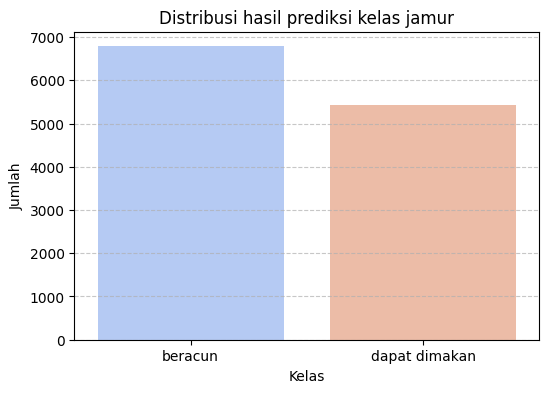

In [22]:
final_prediction_encoded = best_pipeline.predict(test)
final_prediction_text = le.inverse_transform(final_prediction_encoded)

laporan_akhir = pd.DataFrame({
    'id': test_id,
    'kelas': final_prediction_text
})

print("Hasil akhir:")
print(laporan_akhir.head())
kelas_count = laporan_akhir['kelas'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=kelas_count.index, y=kelas_count.values, palette='coolwarm')

plt.title("Distribusi hasil prediksi kelas jamur")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show

In [23]:
submission_path = 'file/submissiontest6.csv'
laporan_akhir.to_csv(submission_path, index=False)